In [1]:
from b_cos.resnet import resnet50
from b_cos.bcosconv2d import BcosConv2d
import torch
import torch.nn as nn
import torch.optim as optim
from torch.hub import load_state_dict_from_url
import matplotlib.pyplot as plt
import torchvision.models as models
from torch.utils.data import DataLoader, random_split, Dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torchvision import transforms, datasets
from tqdm import tqdm
from PIL import Image
import os
import numpy as np
import torch.nn.functional as F

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
class MyToTensor(transforms.ToTensor):

    def __init__(self):
        """
        Same as transforms.ToTensor, except that if input to __call__ is already tensor, the input is returned unchanged
        """
        super().__init__()

    def __call__(self, input_img):
        if not isinstance(input_img, torch.Tensor):
            return super().__call__(input_img)
        return input_img

class AddInverse(nn.Module):

    def __init__(self, dim=1):
        """
            Adds (1-in_tensor) as additional channels to its input via torch.cat().
            Can be used for images to give all spatial locations the same sum over the channels to reduce color bias.
        """
        super().__init__()
        self.dim = dim

    def forward(self, in_tensor):
        out = torch.cat([in_tensor, 1-in_tensor], self.dim)
        return out
    
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize if necessary
    MyToTensor(),            # Converts image to tensor if not already
    AddInverse(dim=0),            # Adds the inverse channels
])

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, folder_paths, transform=None):
        """
        Args:
            folder_paths (dict): Dictionary where keys are folder paths, and values are the labels.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.image_files = []  # Store (image_path, label) tuples
        for fp, label in folder_paths.items():
            # List all subdirectories within the folder
            subfolders = [os.path.join(fp, d) for d in os.listdir(fp) if os.path.isdir(os.path.join(fp, d))]
            for folder_path in subfolders:
                # Collect all image paths from the folder and assign the given label
                self.image_files.extend(
                    [(os.path.join(folder_path, f), label) for f in os.listdir(folder_path) if f.endswith((".png", ".jpg"))]
                )
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path, label = self.image_files[idx]  # Get image path and its label
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


file_path_deepfakebench = {'../../Interpretable-Deep-Fake-Detection/datasets/rgb/FaceForensics++/manipulated_sequences/DeepFakeDetection/c40/frames': 1,
                           "../../Interpretable-Deep-Fake-Detection/datasets/rgb/FaceForensics++/original_sequences/actors/c40/frames": 0}

dataset = CustomImageDataset(file_path_deepfakebench, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

for images, label in dataloader:
    print(f"Batch of images shape: {images.shape}")
    break

Batch of images shape: torch.Size([32, 6, 224, 224])


In [5]:
def load_pretrained_weights(model, model_url):
    # Load the state dict from the URL
    state_dict = load_state_dict_from_url(model_url, progress=True)

    # Rename keys to match custom model layer names and initialize adapted state dict
    adapted_state_dict = {}
    for key, value in state_dict.items():
        # Replace ".weight" with ".linear.weight" if necessary for `BcosConv2d`
        new_key = key.replace("conv", "conv.linear").replace("fc", "fc.linear")
        
        # Only add weights if the shape matches the model's layer
        if new_key in model.state_dict() and model.state_dict()[new_key].shape == value.shape:
            adapted_state_dict[new_key] = value

    # Load the adapted state dict with partial loading (non-strict mode)
    model.load_state_dict(adapted_state_dict, strict=False)

    # Reinitialize the final layer to match the desired output shape (for 2 classes)
    nn.init.kaiming_normal_(model.fc.linear.weight)
    if model.fc.linear.bias is not None:
        model.fc.linear.bias.data.zero_()  # Initialize bias to zero if it exists

# Usage with resnet50
model = resnet50(pretrained=False, progress=True, num_classes=1, groups=32, width_per_group=4)
load_pretrained_weights(model, 'https://download.pytorch.org/models/resnet50-19c8e357.pth')

In [9]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss() #nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1
fraction = 0.1
num_batches = int(len(dataloader) * fraction)

# Training loop with limited batches
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(dataloader, total=num_batches, desc=f'Epoch [{epoch + 1}/{num_epochs}]')
    for batch_idx, (images, labels) in enumerate(progress_bar):
        if batch_idx >= num_batches:
            break  # Stop after reaching the fraction of batches

        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)

        # outputs = outputs.view(outputs.size(0), -1) NEEDED WHEN USING CROSS ENTROPY LOSS & num_classes > 1

        # Convert labels to float for BCEWithLogitsLoss
        labels = labels.float()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        progress_bar.set_postfix({'Loss': running_loss / (batch_idx + 1)})
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / num_batches:.4f}')

Epoch [1/1]: 100%|██████████| 2/2 [01:16<00:00, 38.14s/it, Loss=0.965]

Epoch [1/1], Loss: 0.9653


In [13]:
torch.save(model.state_dict(), 'b_cos_model_resnet50.pth')

In [15]:
model_trained = resnet50(pretrained=False, progress=True, num_classes=1, groups=32, width_per_group=4)

model_trained.load_state_dict(torch.load('b_cos_model_resnet50.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

## Heatmaps

In [16]:
def to_numpy(tensor):
    """
    Converting tensor to numpy.
    Args:
        tensor: torch.Tensor

    Returns:
        Tensor converted to numpy.

    """
    if not isinstance(tensor, torch.Tensor):
        return tensor
    return tensor.detach().cpu().numpy()

def grad_to_img(img, linear_mapping, smooth=15, alpha_percentile=99.5):
    """
    Computing color image from dynamic linear mapping of B-cos models.
    Args:
        img: Original input image (encoded with 6 color channels)
        linear_mapping: linear mapping W_{1\rightarrow l} of the B-cos model
        smooth: kernel size for smoothing the alpha values
        alpha_percentile: cut-off percentile for the alpha value

    Returns:
        image explanation of the B-cos model
    """
    # shape of img and linmap is [C, H, W], summing over first dimension gives the contribution map per location
    contribs = (img * linear_mapping).sum(0, keepdim=True)
    contribs = contribs[0]
    # Normalise each pixel vector (r, g, b, 1-r, 1-g, 1-b) s.t. max entry is 1, maintaining direction
    rgb_grad = (linear_mapping / (linear_mapping.abs().max(0, keepdim=True)[0] + 1e-12))
    # clip off values below 0 (i.e., set negatively weighted channels to 0 weighting)
    rgb_grad = rgb_grad.clamp(0)
    # normalise s.t. each pair (e.g., r and 1-r) sums to 1 and only use resulting rgb values
    rgb_grad = to_numpy(rgb_grad[:3] / (rgb_grad[:3] + rgb_grad[3:]+1e-12))

    # Set alpha value to the strength (L2 norm) of each location's gradient
    alpha = (linear_mapping.norm(p=2, dim=0, keepdim=True))
    # Only show positive contributions
    alpha = torch.where(contribs[None] < 0, torch.zeros_like(alpha) + 1e-12, alpha)
    if smooth:
        alpha = F.avg_pool2d(alpha, smooth, stride=1, padding=(smooth-1)//2)
    alpha = to_numpy(alpha)
    alpha = (alpha / np.percentile(alpha, alpha_percentile)).clip(0, 1)

    rgb_grad = np.concatenate([rgb_grad, alpha], axis=0)
    # Reshaping to [H, W, C]
    grad_image = rgb_grad.transpose((1, 2, 0))
    return grad_image

Batch of images shape: torch.Size([32, 6, 224, 224])


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


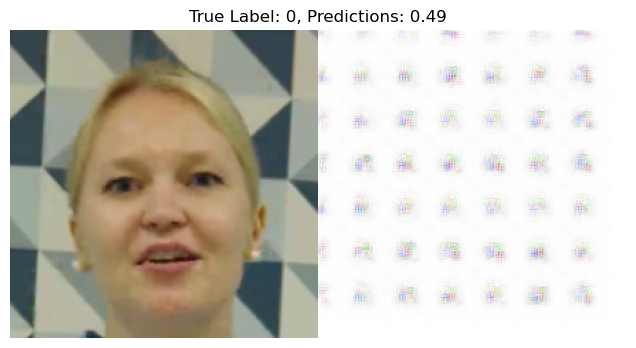

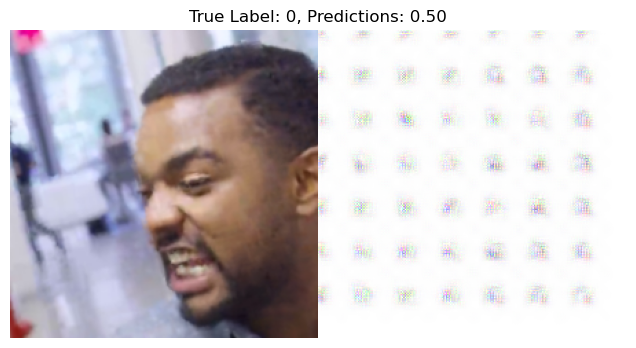

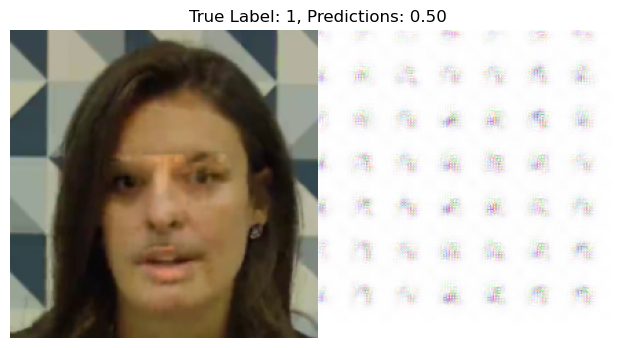

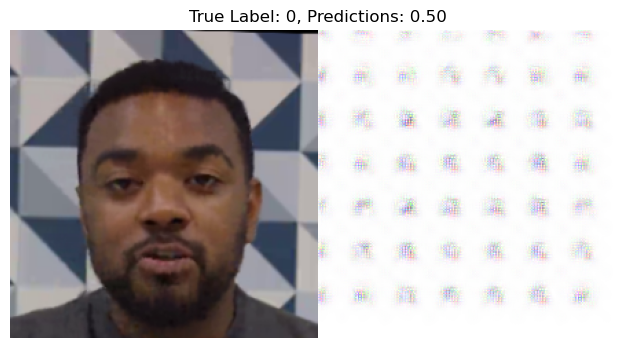

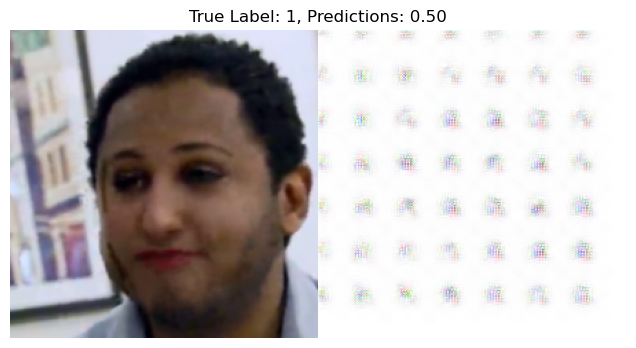

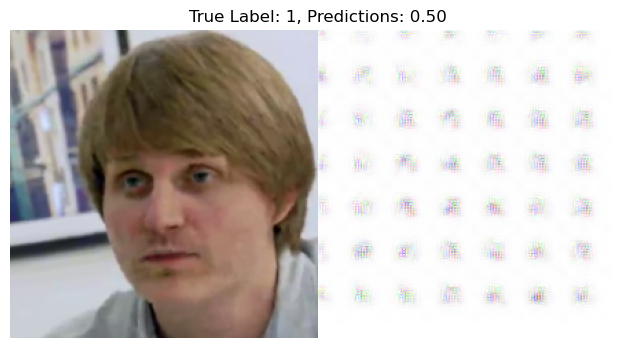

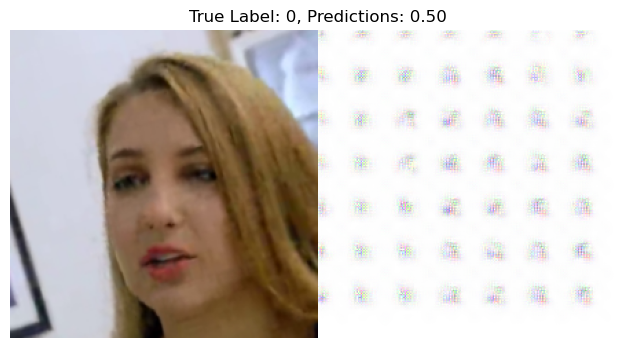

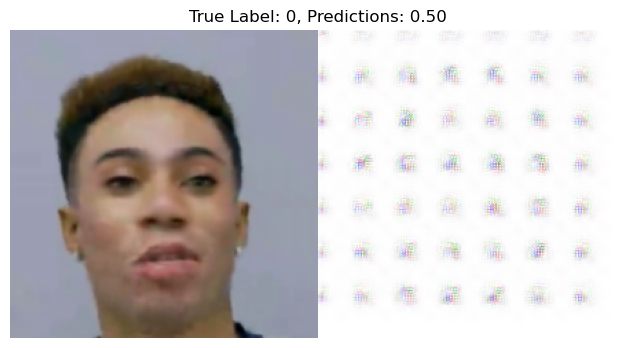

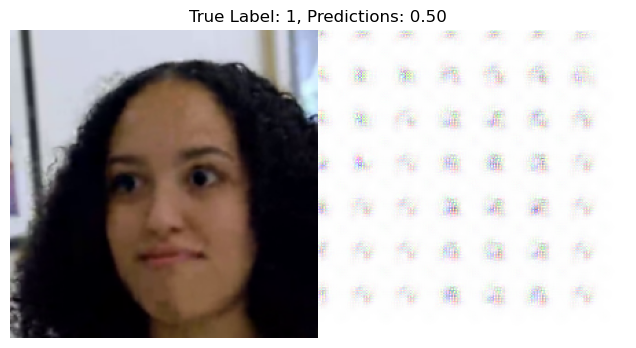

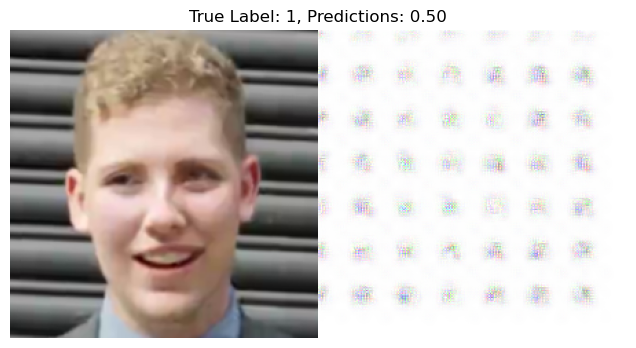

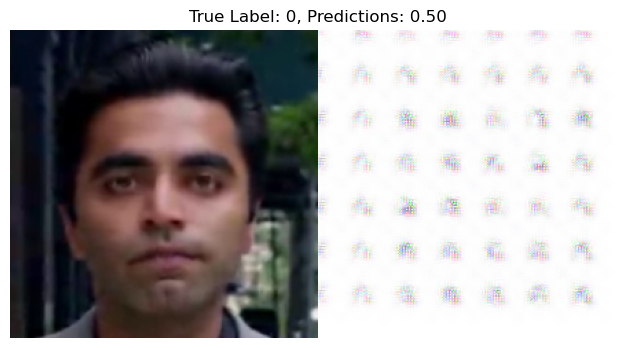

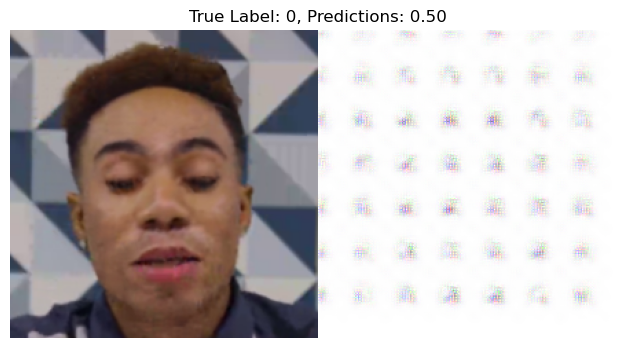

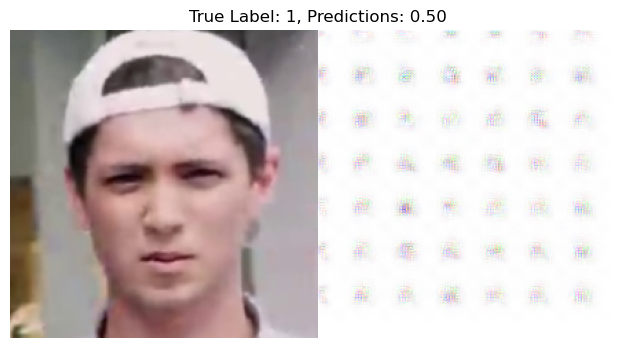

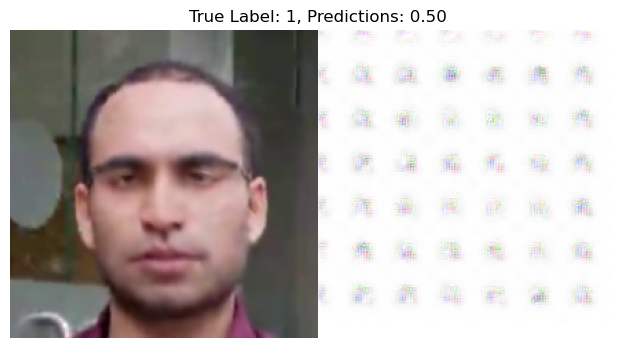

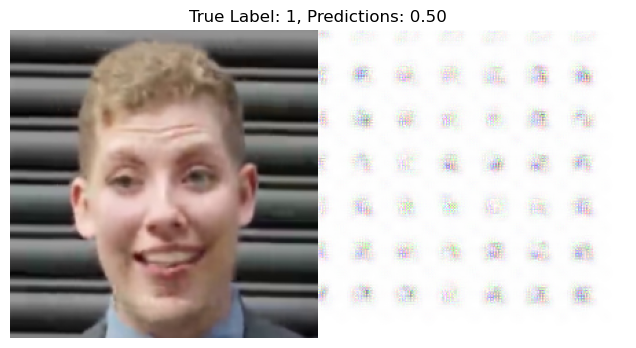

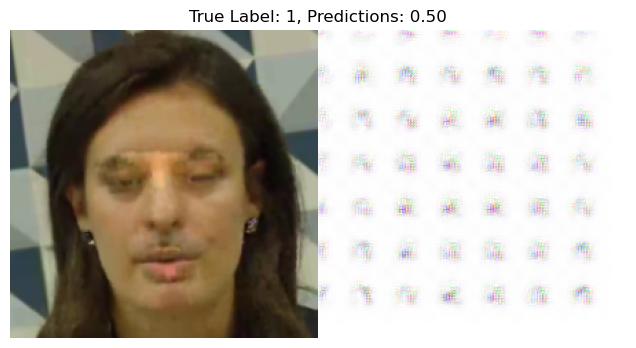

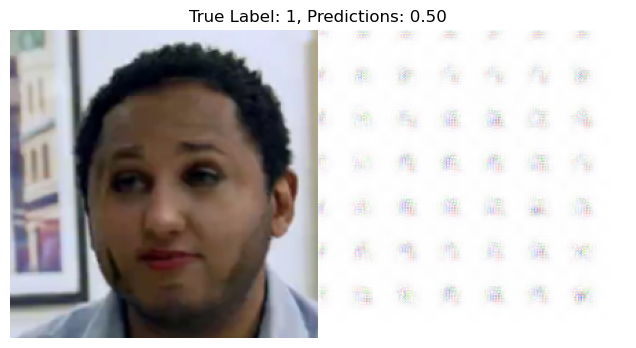

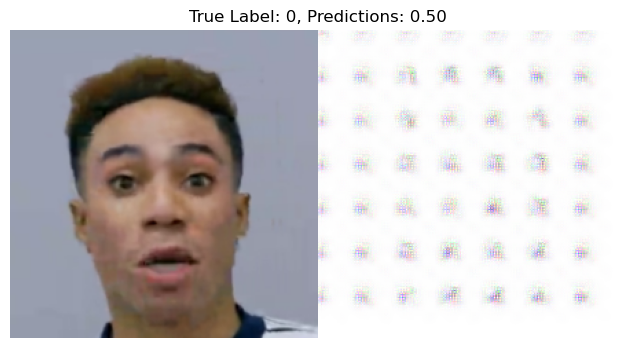

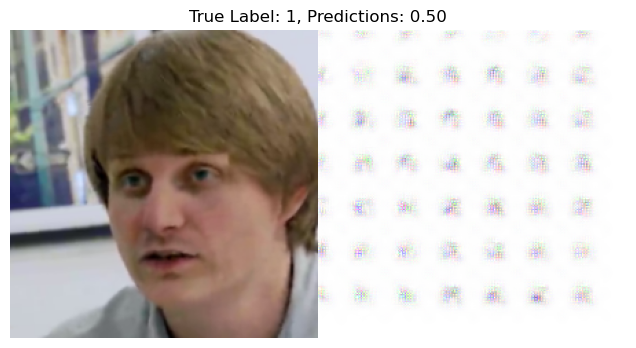

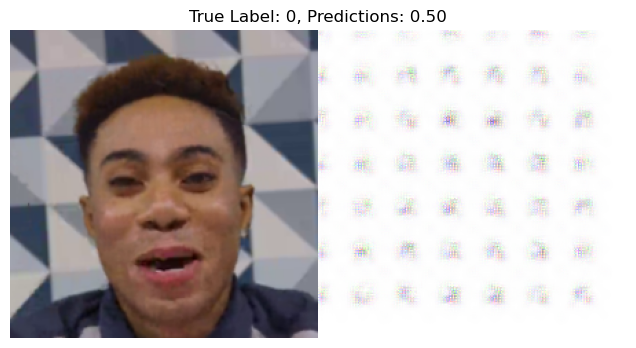

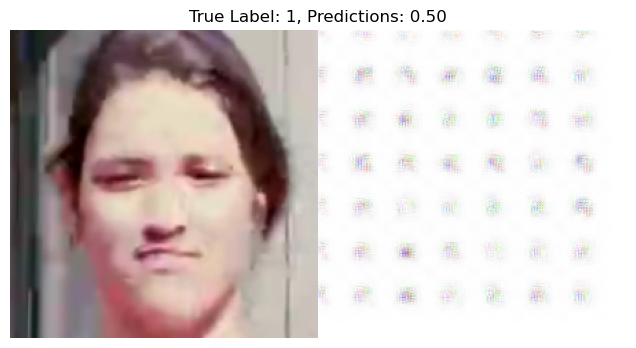

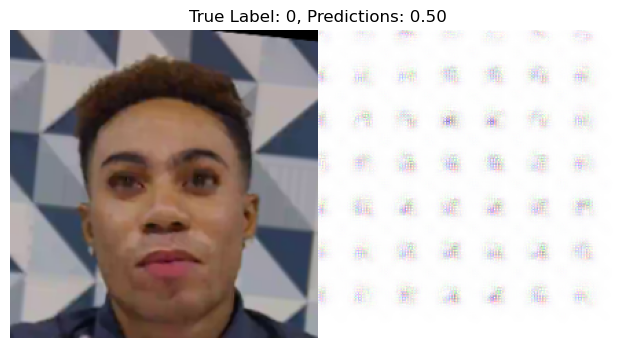

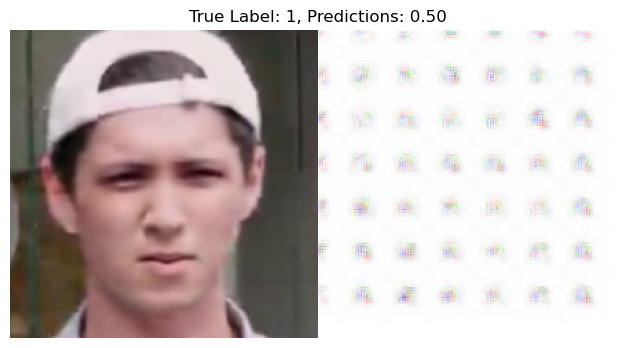

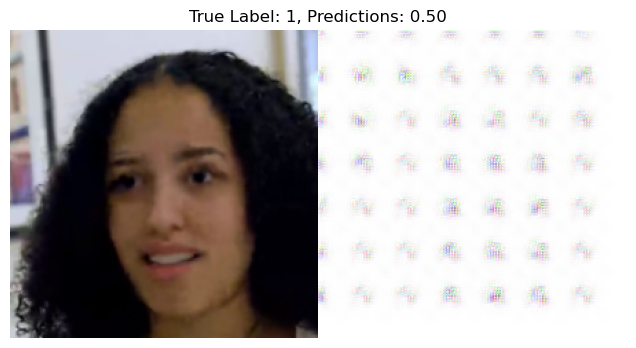

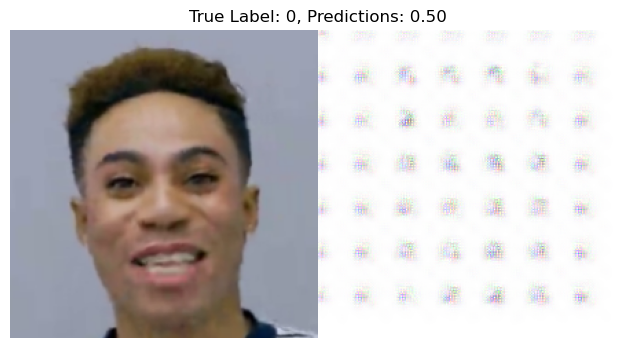

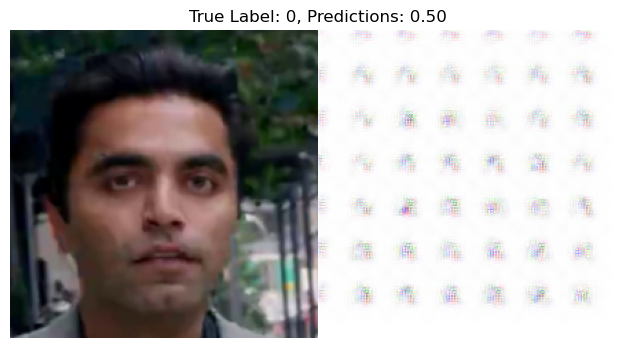

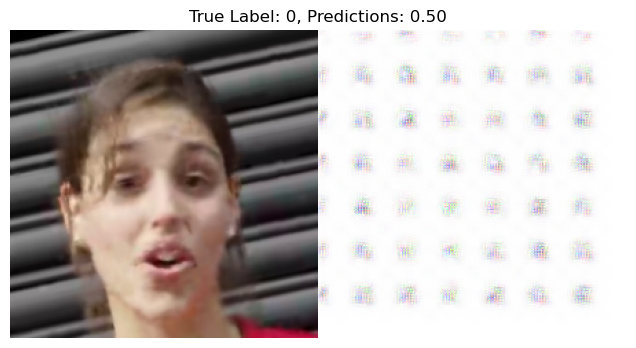

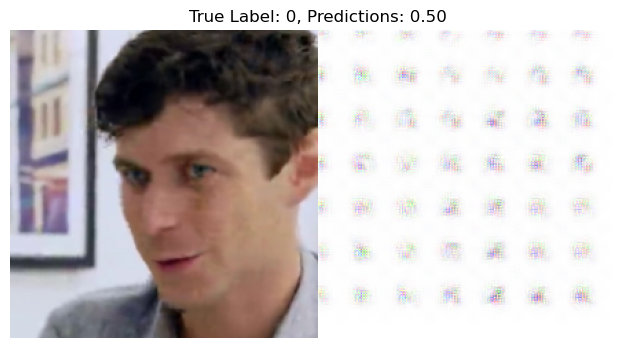

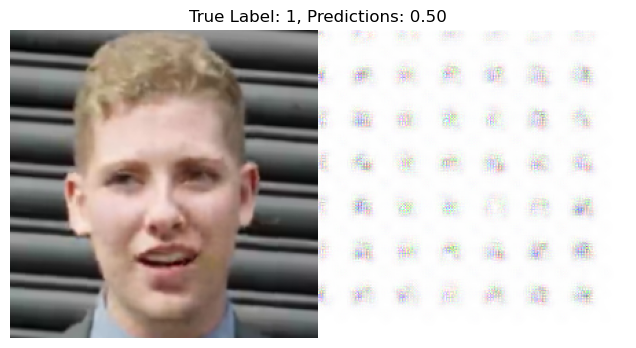

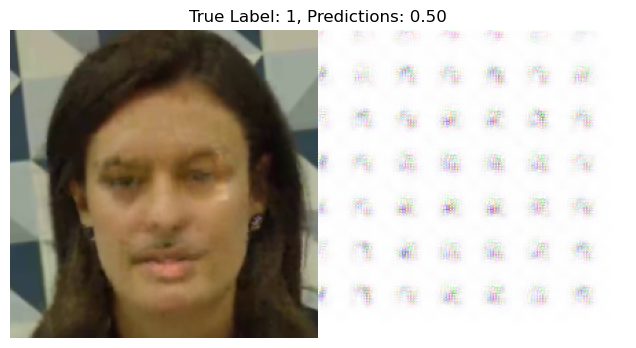

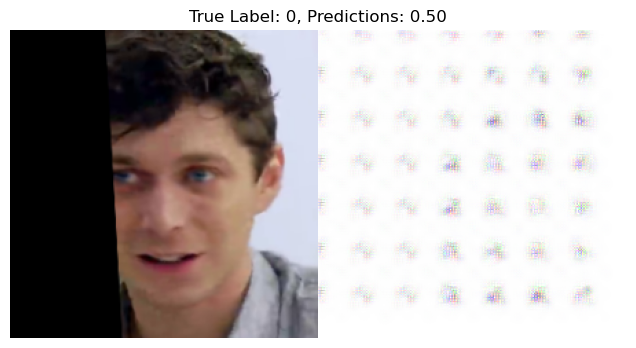

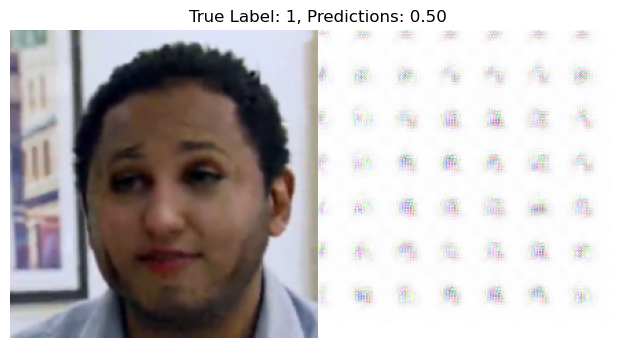

In [17]:
for img_batch, label_batch in dataloader:
    print(f"Batch of images shape: {img_batch.shape}")
    device = "cpu"
    
    # Iterate through each image in the batch
    for i in range(len(img_batch)):
        img = img_batch[i].unsqueeze(0).to(device)  # Process a single image
        label = label_batch[i]

        img = img.requires_grad_(True)

        # Zero the gradients
        model_trained.zero_grad()

        # Forward pass
        out = model_trained(img)

        # Backward pass
        out.backward()

        # Generate attention visualization
        att = grad_to_img(img[0], img.grad[0], alpha_percentile=100, smooth=5)
        att[..., -1] *= to_numpy(out.sigmoid())

        # Prepare the image and attention map for visualization
        att = to_numpy(att)
        img_np = np.array(to_numpy(img[0, :3].permute(1, 2, 0)) * 255, dtype=np.uint8)

        # Plot the results
        fig, ax = plt.subplots(1, figsize=(8, 4))
        plt.imshow(img_np, extent=(0, 224, 0, 224))
        plt.imshow(att, extent=(224, 2 * 224, 0, 224))
        plt.xlim(0, 2 * 224)
        plt.xticks([])
        plt.yticks([])
        plt.title(f"True Label: {label}, Predictions: {out.sigmoid().item():.2f}")
        for spine in ax.spines.values():
            spine.set_visible(False)

        plt.show()

    break  # Exit after processing the first batch


In [18]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_trained.to(device)

# Set model_trained to evaluation mode
model_trained.eval()

# Lists to store all predictions and true labels
all_preds = []
all_labels = []

# Disable gradient calculation
with torch.no_grad():
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)  # Move to device
        outputs = model_trained(images)  # Forward pass
        outputs = outputs.view(outputs.size(0), -1)
        _, predicted = torch.max(outputs.data, 1)  # Get the predicted class
        all_preds.extend(predicted.cpu().numpy())  # Store predictions
        all_labels.extend(labels.cpu().numpy())  # Store true labels

# Calculate and print the accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {accuracy:.2f}')

# Detailed classification report
print(classification_report(all_labels, all_preds, target_names=['Fake', 'Real']))
print(confusion_matrix(all_labels, all_preds))

Test Accuracy: 0.49
              precision    recall  f1-score   support

        Fake       0.49      1.00      0.66       309
        Real       0.00      0.00      0.00       316

    accuracy                           0.49       625
   macro avg       0.25      0.50      0.33       625
weighted avg       0.24      0.49      0.33       625

[[309   0]
 [316   0]]


/opt/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
